# ROSSMANN STORE SALES

## Forecast sales using store, promotion, and competitor data

## The context and understanding the business

Rossmann operates over 3,000 drug stores in 7 European countries. 
Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. 
Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

There are historical sales data for 1,115 Rossmann stores. 

**DATA FIELDS**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set

- **Store** - a unique Id for each store

- **Sales** - the turnover for any given day (this is what you are predicting)

- **Customers** - the number of customers on a given day

- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open

- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

- **StoreType** - differentiates between 4 different store models: a, b, c, d

- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended

- **CompetitionDistance** - distance in meters to the nearest competitor store

- **CompetitionOpenSince [Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

- **Promo** - indicates whether a store is running a promo on that day

- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

- **Promo2Since [Year/Week]** - describes the year and calendar week when the store started participating in Promo2

- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Case link:  https://www.kaggle.com/c/rossmann-store-sales

## 1.0 IMPORTS

In [1]:
# Imports
import math
import json
import pickle
import random
import datetime
import inflection

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy                 as np
import pandas                as pd
import xgboost               as xgb
import seaborn               as sns
import matplotlib            as m
import scipy.stats           as ss
import statsmodels.api       as sm
import matplotlib.pyplot     as plt

from scipy                   import stats
from boruta                  import BorutaPy
from sklearn                 import metrics
from tabulate                import tabulate
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from IPython.display         import Image
from sklearn.pipeline        import Pipeline, FeatureUnion
from sklearn.ensemble        import RandomForestRegressor
from pandas.api.types        import CategoricalDtype
from sklearn.ensemble        import RandomForestRegressor
from matplotlib.gridspec     import GridSpec
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.preprocessing   import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from statsmodels.formula.api import ols
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

%matplotlib inline

###  1.1 Helper Functions

In [2]:
# Function to calculate the association between categorical variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    
    # Chi Square test of independence of variables in a contingency table.
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def jupyter_settings():    
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

# Function Average Model

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs(( y - yhat ) / y  ))

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat )) 
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

# Function Cross Validation
def cross_validation(xtraining, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        if verbose: 
            print('\n KFold number {}'.format(k))
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #train and test data
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset

        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']


        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)
        #prediction
        yhat= m.predict(xvalidation)
        #performance
        model_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        #store performance of each iteration
        mae_list.append(model_result['MAE'])
        mape_list.append(model_result['MAPE'])
        rmse_list.append(model_result['RMSE'])
        
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- '  + np.round(np.std(mae_list),2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)
    }, index=[0])
    

def save_pickle(filename, to_be_saved):
    outfile = open(filename, 'wb')
    pickle.dumps(to_be_saved, outfile)
    outfile.close
def open_pickle(filename):
    infile = open(filename, 'rb')
    opened_file = pickle.load(infile)
    infile.close()
    return opened_file



In [3]:
#jupyter_settings()

###  1.2 Loading data

In [4]:
# Loading data
dataset_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
dataset_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge
dataset_raw = pd.merge(dataset_sales_raw, dataset_store_raw, how='left', on='Store')

In [5]:
dataset_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
959378,149,4,2013-02-21,5663,454,1,1,0,0,d,a,2610.0,7.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## 2.0 DATA DESCRIPTION

In [6]:
# Copy of data
dataset1 = dataset_raw.copy()

In [7]:
# Loading columns
dataset1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
# Rename columns
cols_old = ['Store','DayOfWeek','Date','Sales','Customers','Open','Promo','StateHoliday','SchoolHoliday','StoreType', 
            'Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2', 
            'Promo2SinceWeek','Promo2SinceYear','PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map(snakecase, cols_old) )

dataset1.columns = cols_new
dataset1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [9]:
# Data Dimensions
print('Number of Rows: {}'.format(dataset1.shape[0]))
print('Number of Cols: {}'.format(dataset1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


In [10]:
# Checks data types
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

In [11]:
# Modifying date type
dataset1['date'] = pd.to_datetime(dataset1['date'])
dataset1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 2.1 Check Missing Values (NA)

In [12]:
# Check NA
missing_values = dataset1.isna().sum()
missing_values

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [13]:
# Check % NA
missing_values = missing_values[missing_values > 0]/dataset1.shape[0] 
print(f'{missing_values * 100} %')

competition_distance             0.259730
competition_open_since_month    31.787764
competition_open_since_year     31.787764
promo2_since_week               49.943620
promo2_since_year               49.943620
promo_interval                  49.943620
dtype: float64 %


In [14]:
# Fillout NA
# 1º competition_distance "distance in meters to the nearest competitor store"
dataset1['competition_distance'].max()

75860.0

In [15]:
# Removing NA 'competition_distance' values
def impute_media(df):
    return df.fillna(df.mean())

dataset1.competition_distance = dataset1['competition_distance'].transform(impute_media)

In [16]:
# Fillout NA
# 2º competition_open_since_month "gives the approximate month of the time the nearest competitor was opened"
# replicating the month of the 'date' column in the NA rows
dataset1['competition_open_since_month'] = dataset1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# 3º competition_open_since_year  "gives the approximate year of the time the nearest competitor was opened"
# replicating the year of the 'date' column in the NA rows
dataset1['competition_open_since_year'] = dataset1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [17]:
# Fillout NA
# 4º promo2_since_week "describes the calendar week when the store started participating in Promo2"
# replicating the week of the 'date' column in the NA rows
dataset1['promo2_since_week'] = dataset1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# 5º promo2_since_year "describes the year when the store started participating in Promo2"
# replicating the year of the 'date' column in the NA rows
dataset1['promo2_since_year'] = dataset1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)


In [18]:
# Fillout NA
# 6º promo_interval "describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store"

# Create dictionary to replacing the number with month
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Fillout NA with 0
dataset1['promo_interval'].fillna(0, inplace=True)

# Replacing the number with month using dictionary
dataset1['month_map'] = dataset1['date'].dt.month.map(month_map)

# Check the range 'promo_interval' is within the promotion or not. And in the 'is_promo' column we will have 0 = no promo, 1 = promo
dataset1['is_promo'] = dataset1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [19]:
# Check NA
dataset1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [20]:
dataset1.sample(5).T

,877745,59240,255647,17429,300659
store,1026,146,682,705,839
day_of_week,1,1,4,4,5
date,2013-05-06 00:00:00,2015-06-08 00:00:00,2014-12-11 00:00:00,2015-07-16 00:00:00,2014-10-24 00:00:00
sales,7621,7703,12611,9095,5384
customers,1067,748,2088,1010,692
open,1,1,1,1,1
promo,0,0,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,1
store_type,c,d,b,a,c


In [21]:
# Change Types
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [22]:
# Modifying dates type
dataset1['competition_open_since_month'] = dataset1['competition_open_since_month'].astype(int)
dataset1['competition_open_since_year'] = dataset1['competition_open_since_year'].astype(int)

dataset1['promo2_since_week'] = dataset1['promo2_since_week'].astype(int)
dataset1['promo2_since_year'] = dataset1['promo2_since_year'].astype(int)

In [23]:
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

### 2.2 Descriptive Statistical

In [24]:
# Continuous numeric type variables
dfconname = dataset1.select_dtypes(include=['int64', 'float64', 'int32'])
dfconname

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,1,1900.0,6,2014,1,31,2013,1
1017205,1112,2,0,0,0,0,1,1880.0,4,2006,0,1,2013,0
1017206,1113,2,0,0,0,0,1,9260.0,1,2013,0,1,2013,0
1017207,1114,2,0,0,0,0,1,870.0,1,2013,0,1,2013,0


In [25]:
# Categorical type variables
dfcatname = dataset1.select_dtypes(exclude=['int64', 'float64', 'int32', 'datetime64[ns]'])
dfcatname

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
...,...,...,...,...,...
1017204,a,a,a,"Jan,Apr,Jul,Oct",Jan
1017205,a,c,c,0,Jan
1017206,a,a,c,0,Jan
1017207,a,a,c,0,Jan


In [26]:
# Numerical Attributes
# 1º Central Tendency - mean, median
ct1 = pd.DataFrame(dfconname.apply(np.mean)).T
ct2 = pd.DataFrame(dfconname.apply(np.median)).T

# 2º Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(dfconname.apply(np.std)).T
d2 = pd.DataFrame(dfconname.apply( min )).T
d3 = pd.DataFrame(dfconname.apply( max )).T
d4 = pd.DataFrame(dfconname.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(dfconname.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(dfconname.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
#renaming columns
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,75860.0,75840.0,5430.085652,2330.0,7705.293872,2.932345,13.041687
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [27]:
# Categorical Attributes

# Check unique values of each Categorical Attributes
dfcatname.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

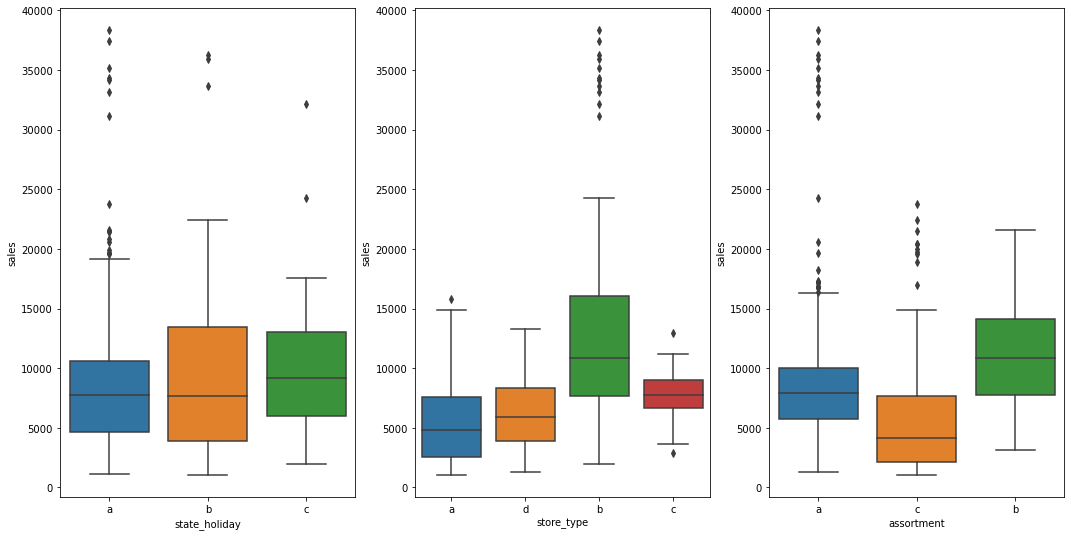

In [28]:
aux1 = dataset1[(dataset1['state_holiday'] !='0') & (dataset1['sales']) > 0] # Exclude days without sales

# Plot graphics
plt.figure(figsize=(18, 9))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

## 3.0 FEATURE ENGINEERING

### 3.1 Hypothesis Mind Map (Insights)

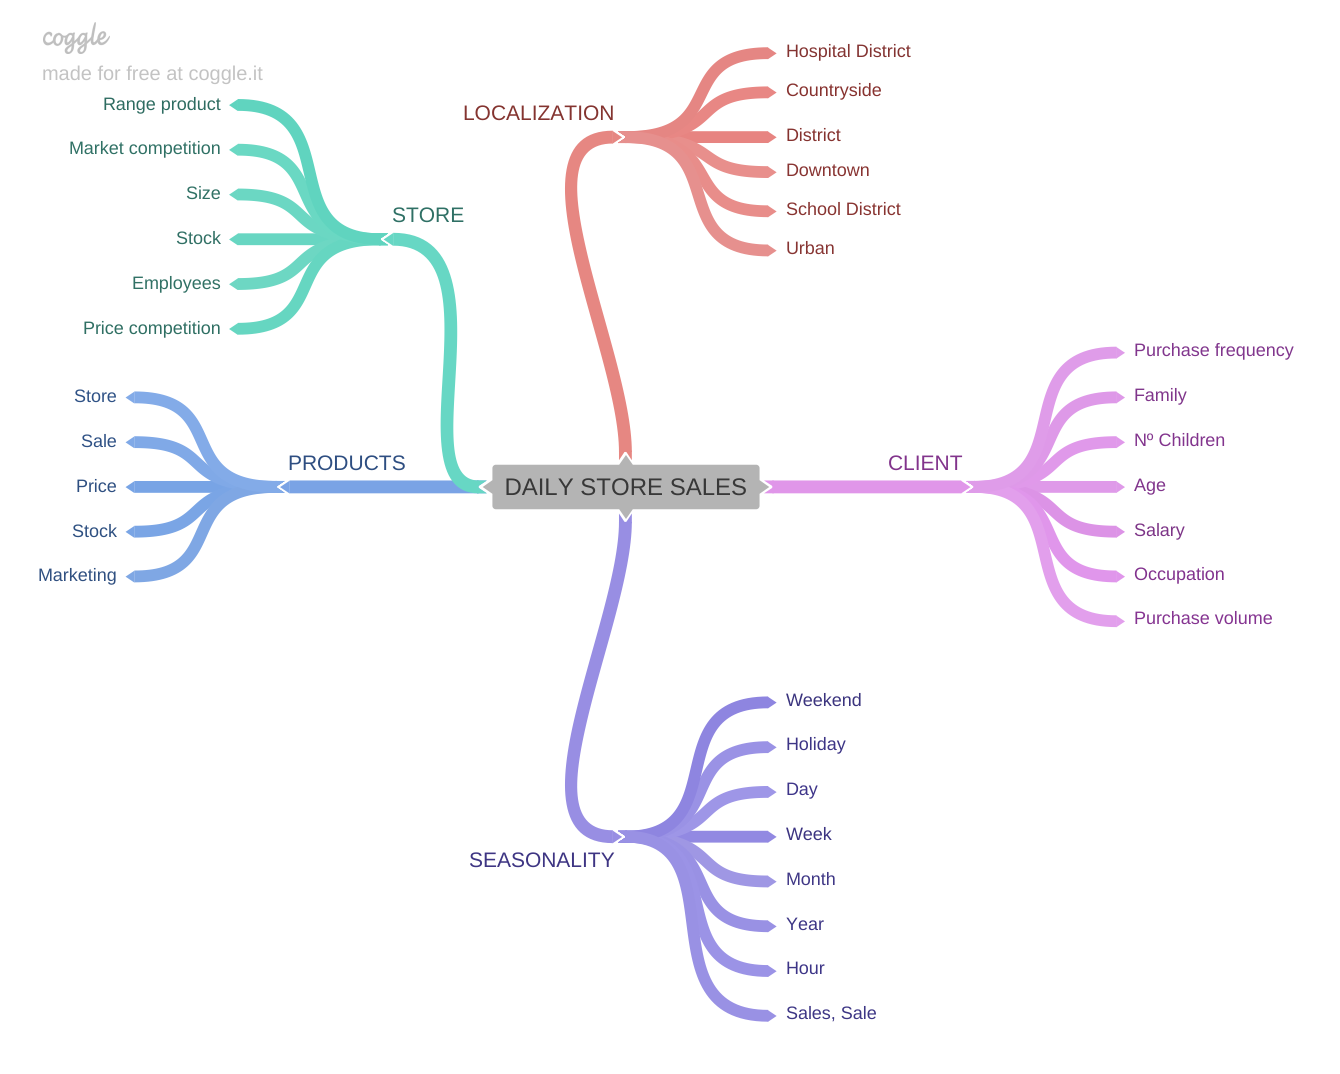

In [29]:
Image( 'img/DAILY_STORE_SALES.png' )

### 3.2 Hypothesis Creation

**1º PRODUCT HYPOTHESIS**

I - Stores that invest more in marketing sell more

II - Stores with greater product exposure sell more

III - Stores with lower-priced products sell more

IV - Stores with bigger discounts sell more

V - Stores with a longer promotion period sell more

VI - Stores with more promotion days sell more

VII - Stores with more consecutive promotions sell more


**2º STORE HYPOTHESIS**

I - Stores with more employees sell more

II - Stores with large stocks sell more

III - Large stores sell more

IV - Stores with a greater variety of products sell more

V - Stores with closer competitors sell less

VI - Stores with old competitors sell more
 

**3º SEASONALITY HYPOTHESIS**

I - Stores open during Christmas break sell more

II - Stores sell more over the years

III - Stores sell more in the second half of the year

IV - Stores sell more after the 10th of each month

V - Stores sell less on weekends

VI - Stores sell less during school holidays
 

### 3.3 Final List of Hypotheses

I - Stores with a greater variety of products sell more

II - Stores with closer competitors sell less

III - Stores with old competitors sell more

IV - Stores with a longer promotion period sell more

V - Stores with more promotion days sell more

VI - Stores with more consecutive promotions sell more

VII - Stores open during Christmas break sell more

VIII - Stores sell more over the years

IX - Stores sell more in the second half of the year

X - Stores sell more after the 10th of each month

XI - Stores sell less on weekends

XII - Stores sell less during school holidays



### 3.4 Feature Engineering

In [30]:
# Copy of data
dataset2 = dataset1.copy()

In [31]:
# Deriving the variables

# 1º Derive year
dataset2['year'] = dataset2['date'].dt.year

# 2º Derive month
dataset2['month'] = dataset2['date'].dt.month

# 3º Derive day
dataset2['day'] = dataset2['date'].dt.day

# 4º Derive week of year
dataset2['week_of_year'] = dataset2['date'].dt.weekofyear

# 5º Derive year week
dataset2['year_week'] = dataset2['date'].dt.strftime ('%Y-%W')

# 6º Derive competition since
# First step is to unite 'year' and 'month'
dataset2['competition_since'] = dataset2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
# Second step is to derive, subtracting 'date' from 'competition_since'
dataset2['competition_time_month'] = ((dataset2['date'] - dataset2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# 7º Derive promo since
# First step is to unite 'year' and 'week'
dataset2['promo_since'] = dataset2['promo2_since_year'].astype(str) + '-' + dataset2['promo2_since_week'].astype(str)
# Second step is convert 'promo_since' to date 
dataset2['promo_since'] = dataset2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
# Third step is derive, subtracting 'date' from 'promo_since' 
dataset2['promo_time_week'] = ((dataset2['date'] - dataset2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# 8º Derive assortment
dataset2['assortment'] = dataset2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# 9º Derive state holiday
dataset2['state_holiday'] = dataset2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [32]:
dataset2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 4.0 VARIABLE FILTERING

In [33]:
# Copy of data
dataset3 = dataset2.copy()

In [34]:
dataset3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 4.1 Line filtering

In [35]:
# Restrictions '0 = no sales'
dataset3 = dataset3[(dataset3['open'] !=0) & (dataset3['sales'] >0)]

### 4.2 Selection of columns

In [36]:
# Delet restrictions
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
dataset3 = dataset3.drop(cols_drop, axis=1)

In [37]:
dataset3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 5.0 EXPLORATORY DATA ANALYSIS

In [38]:
# Copy of data
dataset4 = dataset3.copy()

### 5.1 Univariate Analysis

#### 5.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

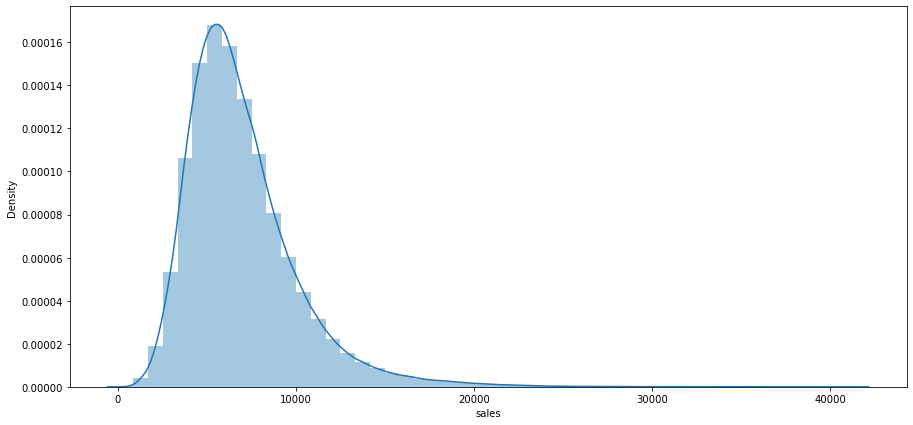

In [39]:
# Plot distribution density
plt.figure(figsize = (15,7))
sns.distplot(dataset4 ['sales'])

#### 5.1.2 Numerical Variable

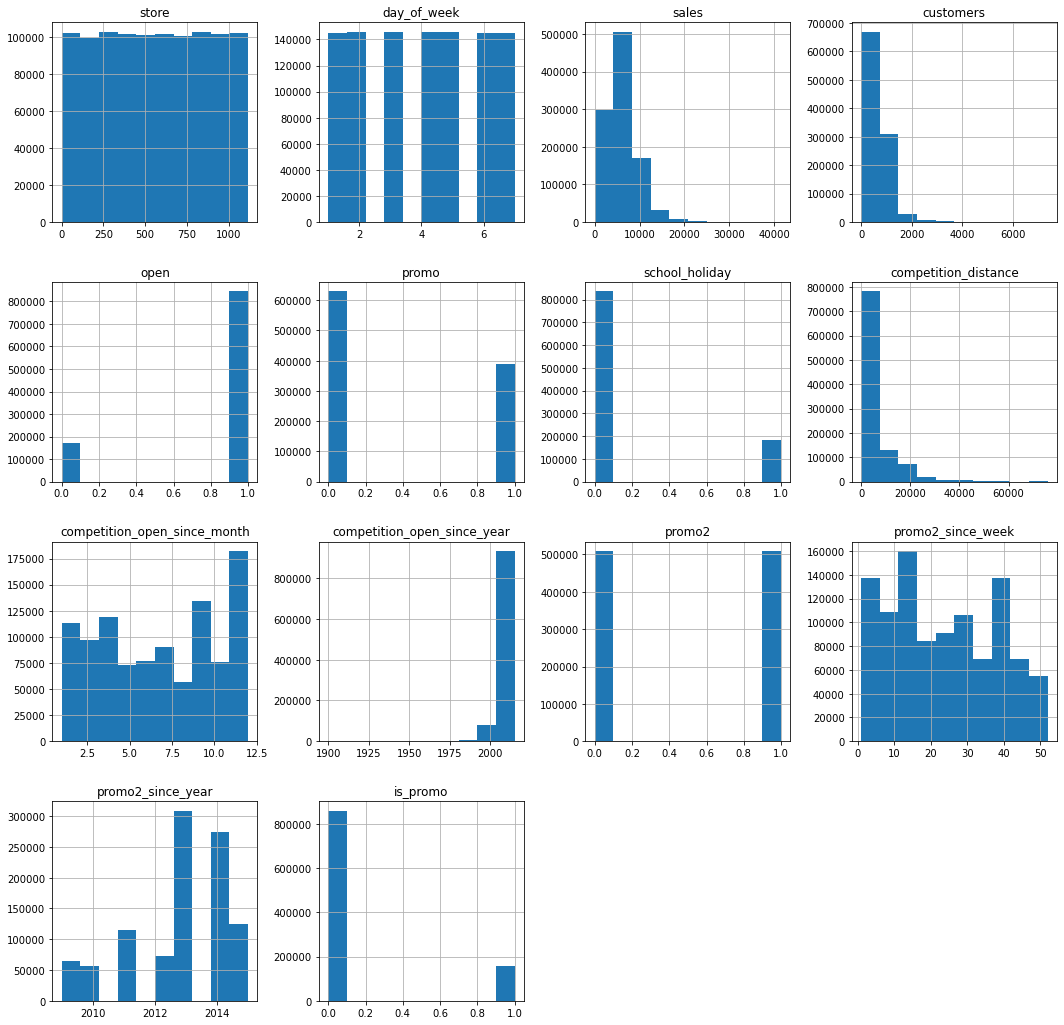

In [40]:
# Plot histogram of all numeric variables
dfconname.hist(figsize = (18,18));

#### 5.1.3 Categorical Variable

In [41]:
dataset4 ['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [42]:
dataset4 ['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [43]:
dataset4 ['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

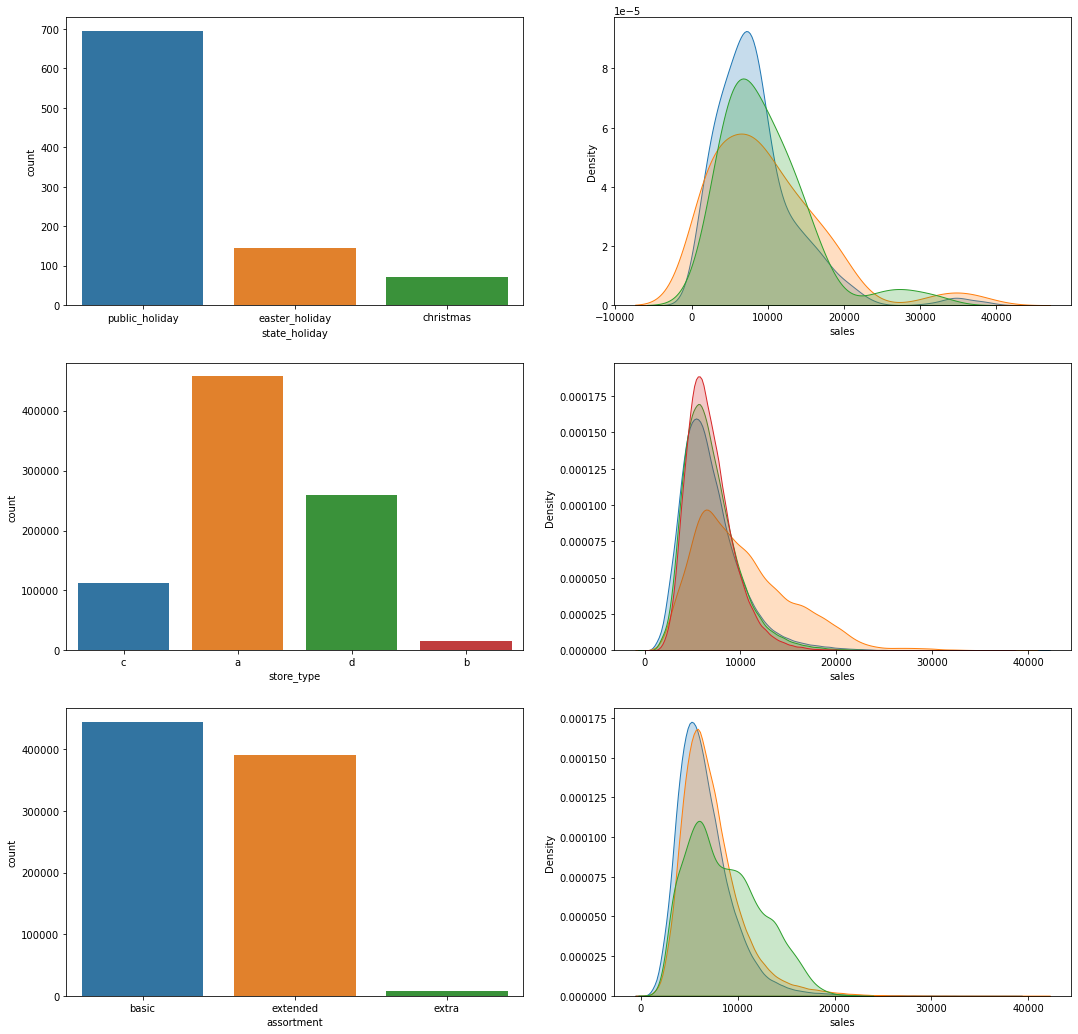

In [44]:
# state_holiday

plt.figure(figsize=(18, 18))

plt.subplot(3, 2, 1)
a = dataset4[dataset4 ['state_holiday'] !='regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3, 2, 2)
sns.kdeplot (dataset4 [dataset4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot (dataset4 [dataset4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot (dataset4 [dataset4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot( dataset4['store_type'] )

plt.subplot(3, 2, 4)
sns.kdeplot (dataset4 [dataset4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot (dataset4 [dataset4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot (dataset4 [dataset4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot (dataset4 [dataset4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot( dataset4['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot (dataset4 [dataset4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot (dataset4 [dataset4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot (dataset4 [dataset4['assortment'] == 'extra']['sales'], label='extra', shade=True)

### 5.2 Bivariate Analysis

#### H1 - Stores with a greater variety of products sell more

<AxesSubplot:xlabel='year_week'>

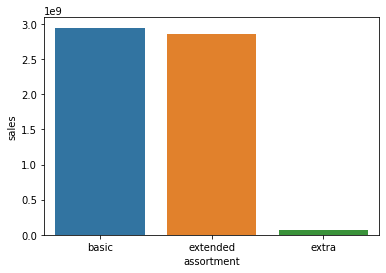

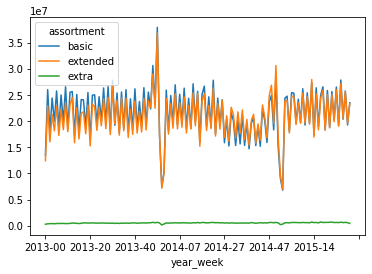

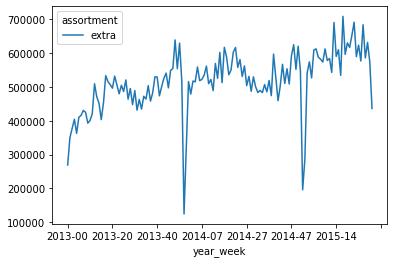

In [45]:
# Validating H1
aux1 = dataset4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

# Checking for changes over time 
aux2 = dataset4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# Plot 'extra'
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

**Conclusion H1**

False hypothesis

- Assuming the 'extra' as having a greater variety of products, concludes that Stores with a greater variety of products sell less.

#### H2 - Stores with closer competitors sell less

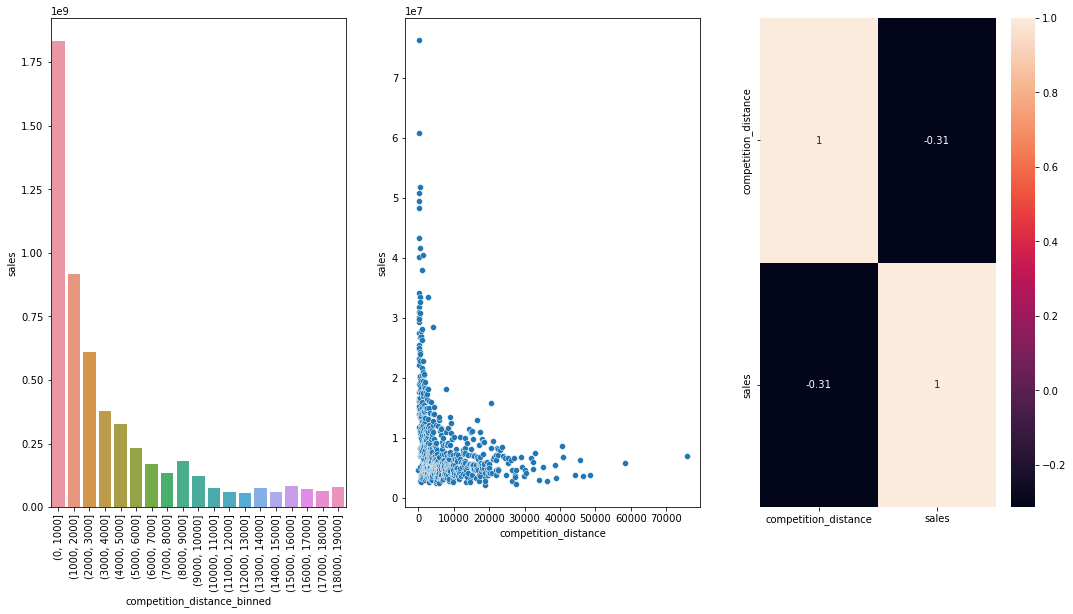

In [46]:
# Validating H2
plt.figure(figsize=(18, 9))


# Plot Bar graph
plt.subplot(1, 3, 1)
plt.xticks(rotation=90)
aux1 = dataset4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list( np.arange( 0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned').sum().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2);


# Plot scatter graph
plt.subplot(1, 3, 2)
aux1 = dataset4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot( x='competition_distance', y='sales', data=aux1);


# Plot correlation between 'competition_distance' and 'sales'
plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);


**Conclusion H2**

False hypothesis

- Stores with closer competitors sell more.

#### H3 - Stores with old competitors sell more

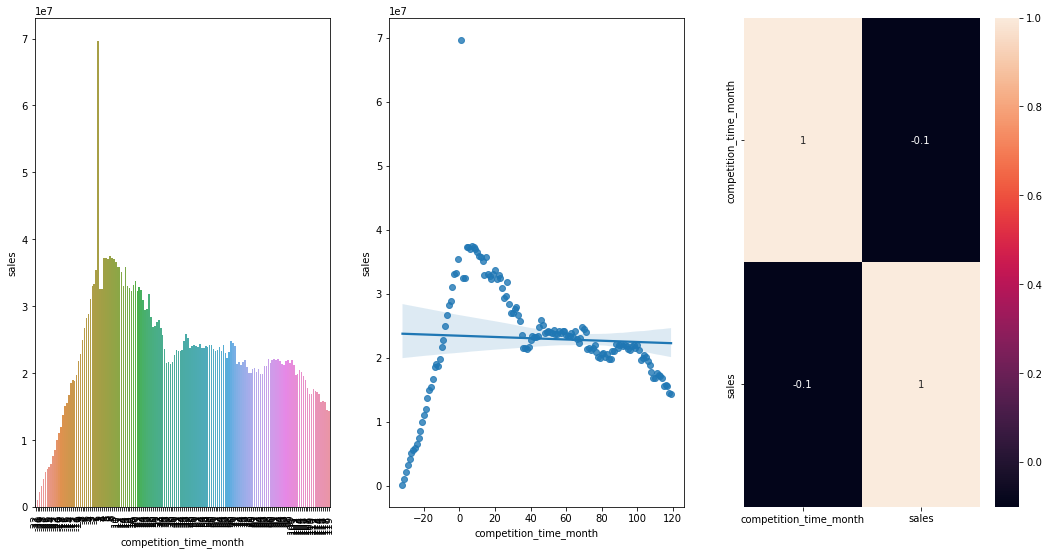

In [47]:
# Validating H3
plt.figure(figsize=(18, 9))

# Plot Bar graph
plt.subplot(1, 3, 1)
aux1 = dataset4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

# Plot reg graph
plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2);

# Plot correlation between 'competition_time_month' and 'sales'
plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);


**Conclusion H3**

False hypothesis

- Stores with old competitors sell less.

####  H4 - Stores with a longer promotion period sell more





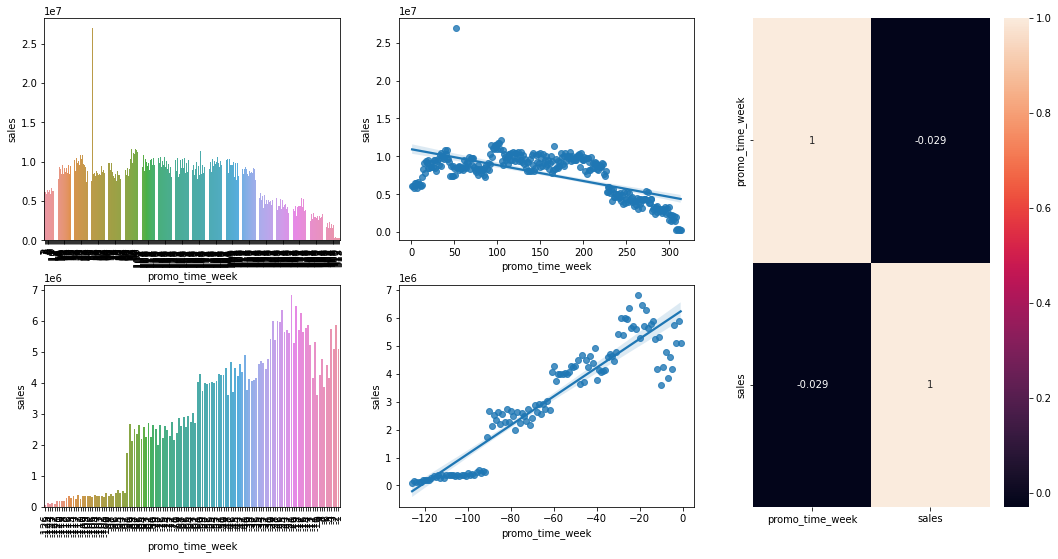

In [48]:
# Validating H4
plt.figure(figsize=(18, 9))

aux1 = dataset4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

# Extended Promotion
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);

# Regular promotion
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);


# Plot correlation between 'promo_time_week' and 'sales'
plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method='pearson'), annot=True);


**Conclusion H4**

False hypothesis

- Stores with a longer promotion period sell less.

- Stores sells regularly for a period and then sales drop.

#### <s>H5 - Stores with more promotion days sell more<s>

As it is similar to the previous hypothesis 'H4', this hypothesis will be evaluated in a second cycle of CRISP.

#### H6 - Stores with more consecutive promotions sell more

In [49]:
# Validating H6
dataset4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


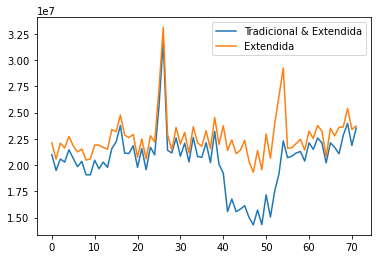

In [50]:
aux1 = dataset4[( dataset4['promo'] == 1) & (dataset4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = dataset4[( dataset4['promo'] == 1) & (dataset4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


**Conclusion H6**

False hypothesis

- Stores with more consecutive promotions sell less.

#### H7 - Stores open during Christmas break sell more

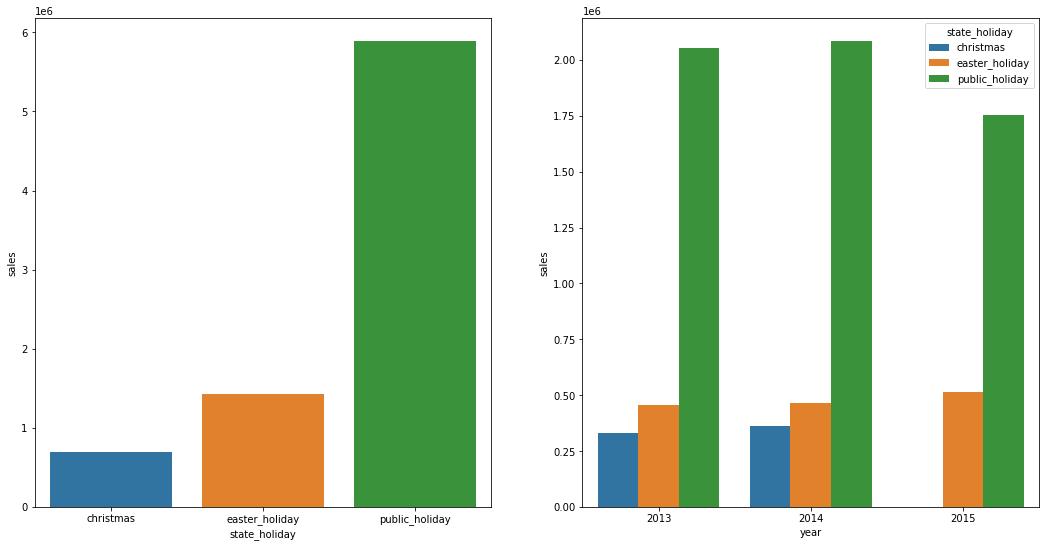

In [51]:
# Validating H7
plt.figure(figsize=(18, 9))

aux = dataset4[dataset4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);


**Conclusion H7**

False hypothesis

- Stores open during Christmas break sell less.

#### H8 - Stores sell more over the years

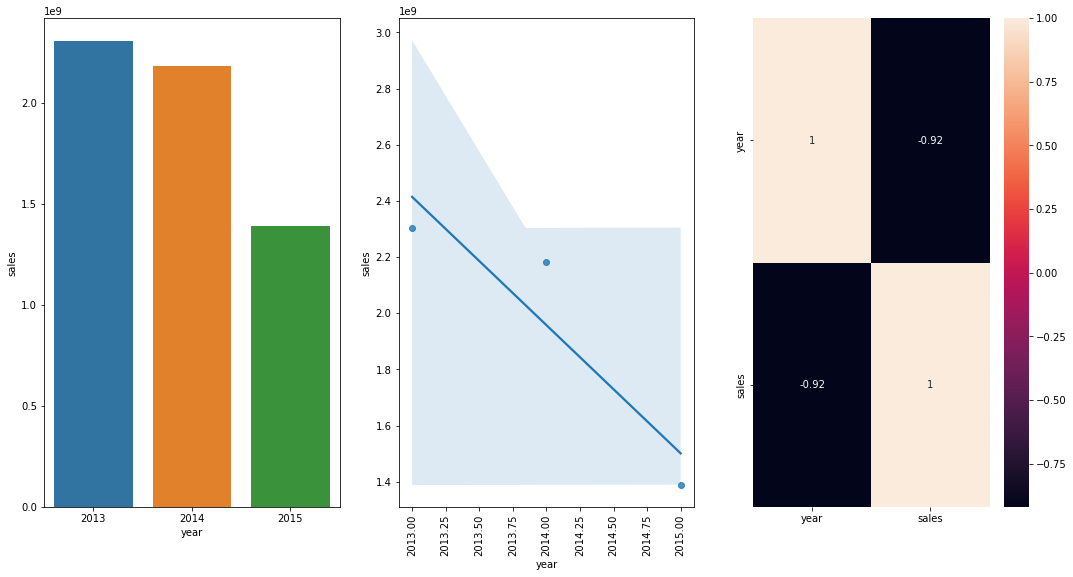

In [52]:
# Validating H8
plt.figure(figsize=(18, 9))

aux1 = dataset4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1);
plt.xticks(rotation=90);

# Plot correlation between 'year' and 'sales'
plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);


**Conclusion H8**

False hypothesis

- Stores sell less over the years.

#### H9 - Stores sell more in the second halfyear of the year

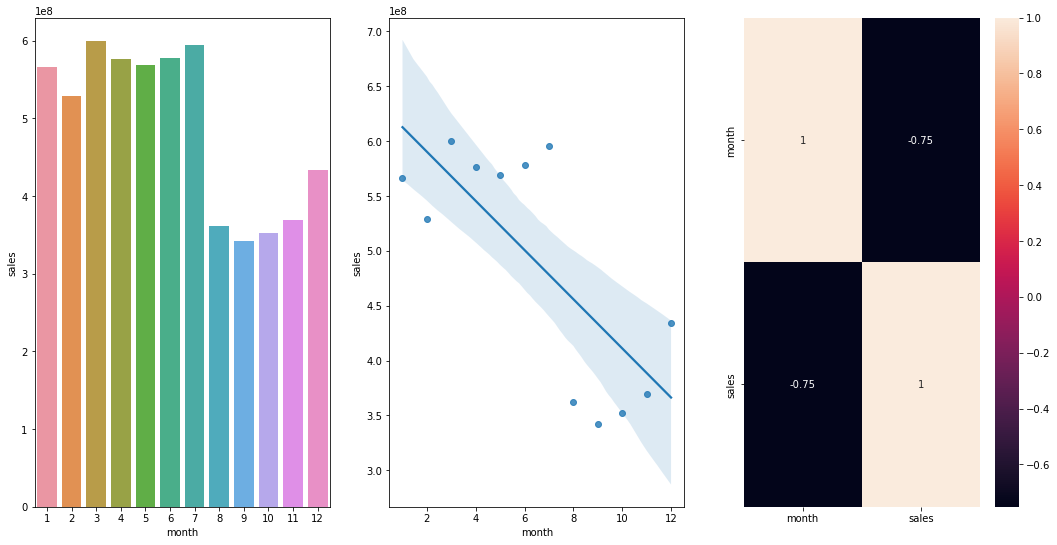

In [53]:
# Validating H8
plt.figure(figsize=(18, 9))

aux1 = dataset4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1);

# Plot correlation between 'month' and 'sales'
plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

**Conclusion H9**

False hypothesis

- Stores sell less in the second halfyear of the year

#### H10 - Stores sell more after the 10th of each month

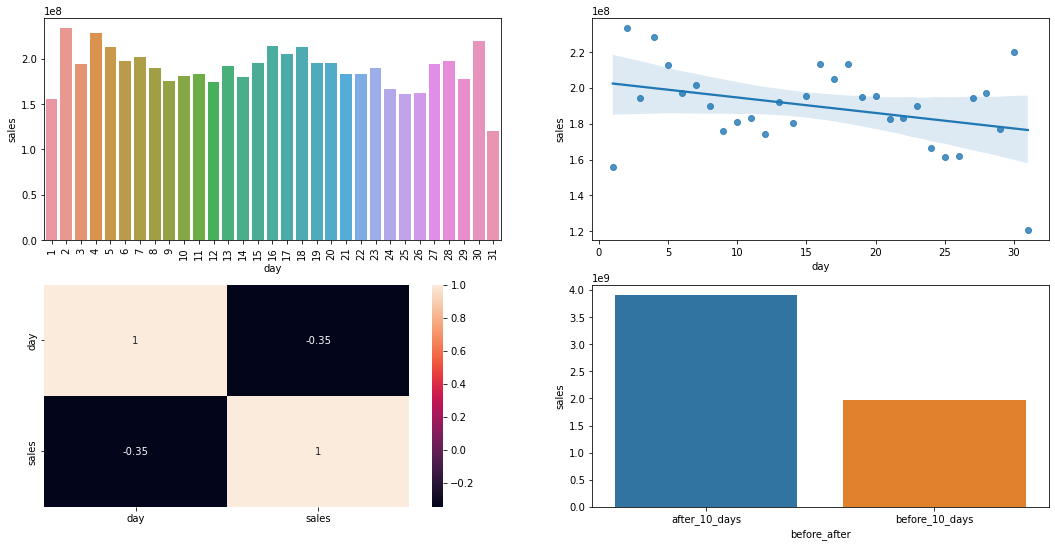

In [54]:
# Validating H8
plt.figure(figsize=(18, 9))

aux1 = dataset4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1);

# Plot correlation between 'day' and 'sales'
plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

# Plot before and after the 10th of each month
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot( x='before_after', y='sales', data=aux2);


**Conclusion H10**

True hypothesis

- Stores sell more after the 10th of each month

#### H11 - Stores sell less on weekends

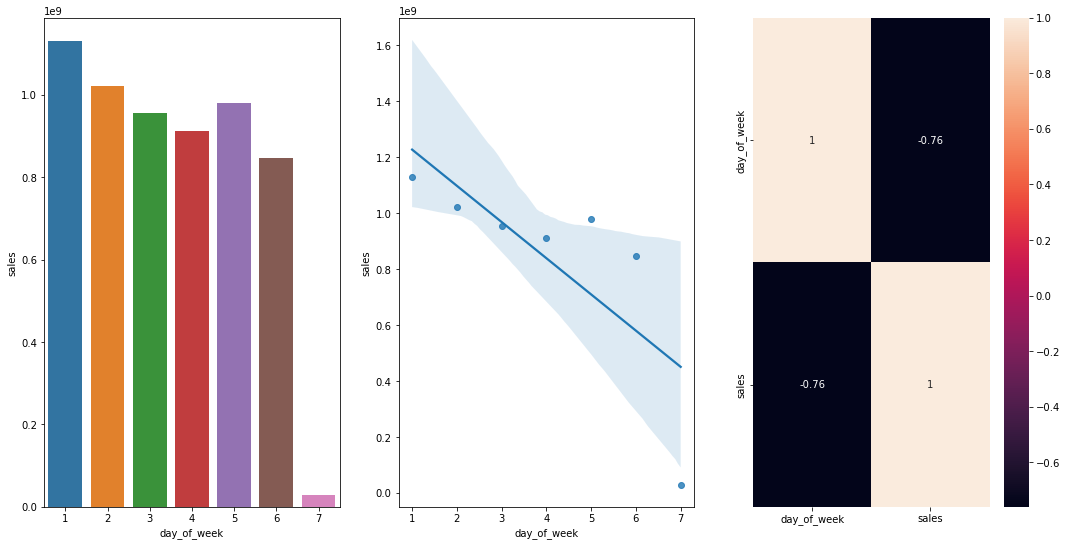

In [55]:
# Validating H11
plt.figure(figsize=(18, 9))

aux1 = dataset4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1);

# Plot correlation between 'day_of_week' and 'sales'
plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

**Conclusion H11**

True hypothesis

- Stores sell less on weekends

#### H12 - Stores sell less during school holidays

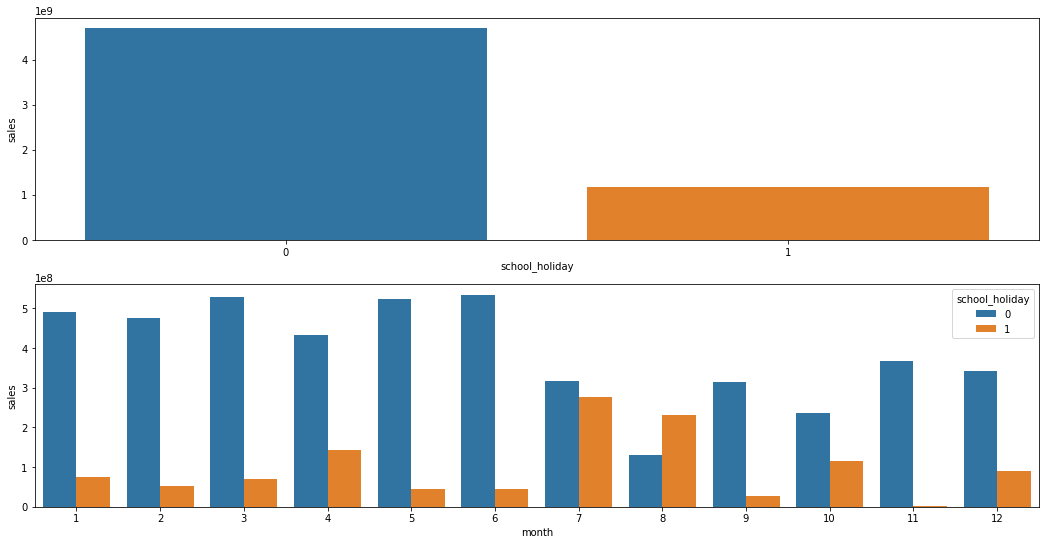

In [56]:
# Validating H12
plt.figure(figsize=(18, 9))

aux1 = dataset4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1);

aux2 = dataset4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2);


**Conclusion H12**

True hypothesis
 
- Shops sell less during school holidays except July and August

#### 5.2.1 Summary of Hypotheses

In [57]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Average'],
       ['H3', 'False', 'Average'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Average'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low'],
      ]
print( tabulate( tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Average
H3            False         Average
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Average
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


### 5.3 Multivariate Analysis

#### 5.3.1 Numerical Attributes

In [58]:
dfconname.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


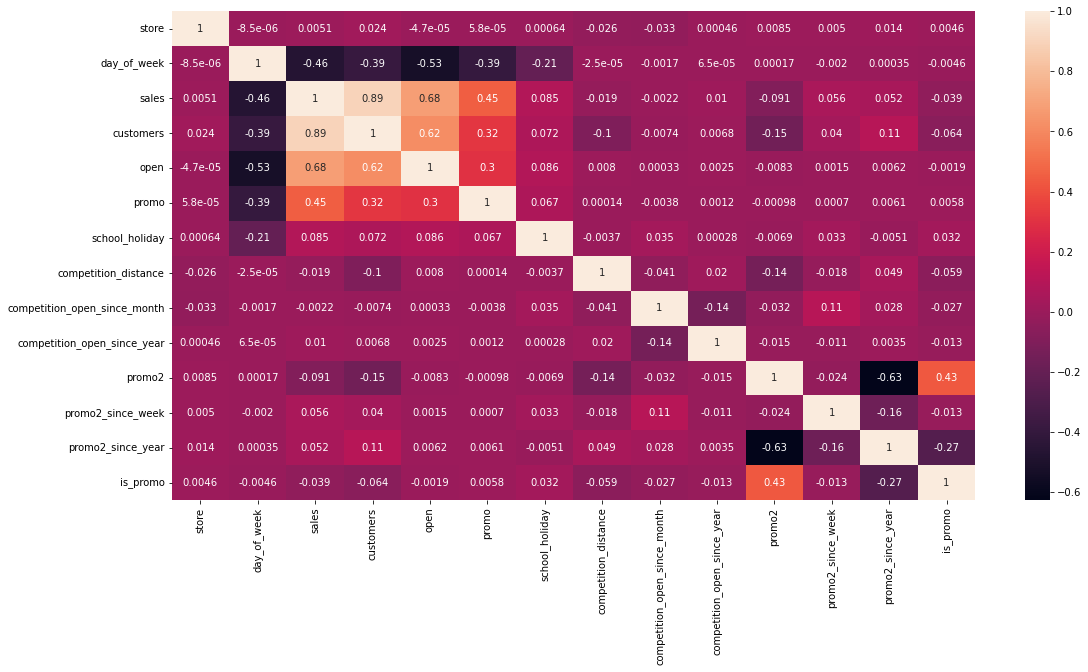

In [59]:
plt.figure(figsize=(18, 9))

correlation = dfconname.corr( method='pearson')
sns.heatmap( correlation, annot=True);

#### 5.3.2 Categorical Attributes

In [60]:
dfcatname.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [61]:
# Only categorical data
a = dataset4.select_dtypes( include='object')

In [62]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [63]:
confusion_matrix = pd.crosstab( a['state_holiday'], a['store_type'] ).values

In [64]:
# Function to calculate the association between categorical variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    
    # Chi Square test of independence of variables in a contingency table.
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [65]:
cramers_v( a['state_holiday'], a['store_type'] )

0.071039693758565

In [66]:
# Calculate cramers V
a1 = cramers_v( a['state_holiday'], a['state_holiday'] )
a2 = cramers_v( a['state_holiday'], a['store_type'] )
a3 = cramers_v( a['state_holiday'], a['assortment'] )

a4 = cramers_v( a['store_type'], a['state_holiday'] )
a5 = cramers_v( a['store_type'], a['store_type'] )
a6 = cramers_v( a['store_type'], a['assortment'] )

a7 = cramers_v( a['assortment'], a['state_holiday'] )
a8 = cramers_v( a['assortment'], a['store_type'] )
a9 = cramers_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame(  { 'state_holiday' : [a1, a2, a3], 
                    'store_type' : [a4, a5, a6],
                    'assortment' : [a7, a8, a9]   })

d = d.set_index( d.columns)  
d

,state_holiday,store_type,assortment
state_holiday,1.000000,0.071040,0.067519
store_type,0.071040,1.000000,0.538454
assortment,0.067519,0.538454,1.000000


<AxesSubplot:>

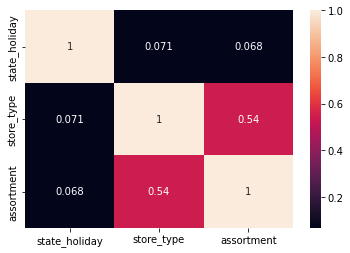

In [67]:
sns.heatmap( d, annot=True)

## 6.0 DATA PREPARATION

In [68]:
# Copy of data
dataset5 = dataset4.copy()

### 6.1 Normalization

- Checking item 5.1.2 of the exploratory data analysis, we identified that we do not have variables with a Normal distribution, so no Normalization test will be performed.

### 6.2 Rescaling

In [69]:
# Numeric type variables
a = dataset5.select_dtypes(include=['int64', 'float64', 'int32'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


##### Competition distance

<AxesSubplot:xlabel='competition_distance'>

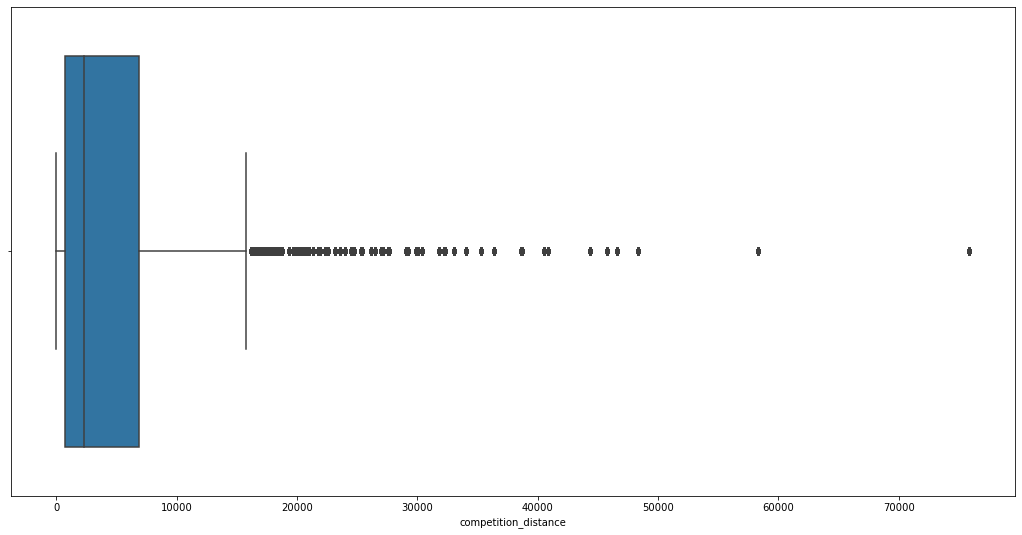

In [70]:
plt.figure(figsize=(18, 9))
sns.boxplot( dataset5['competition_distance'] )

In [71]:
rs = RobustScaler()
dataset5['competition_distance'] = rs.fit_transform( dataset5[['competition_distance']].values )
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

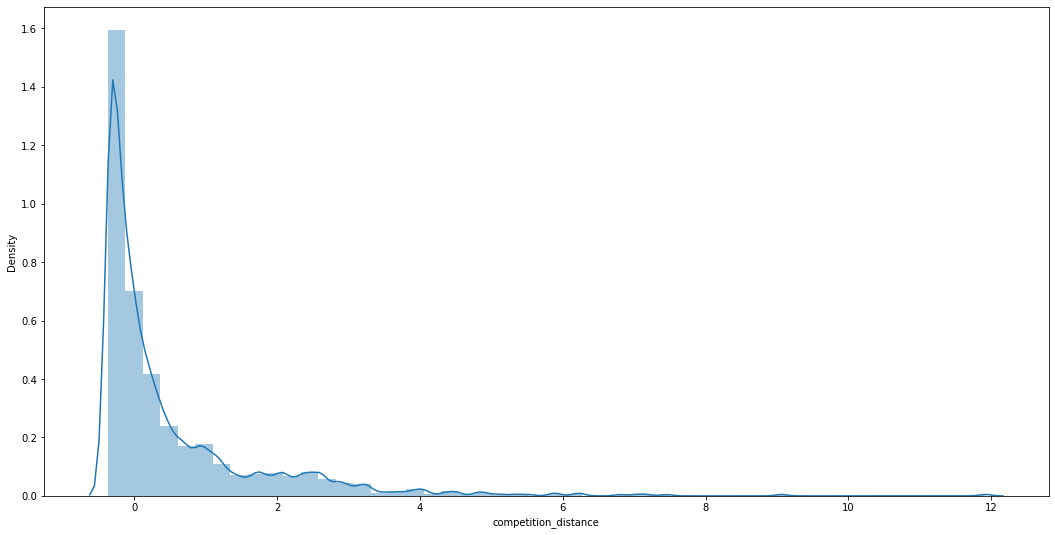

In [72]:
plt.figure(figsize=(18, 9))
sns.distplot( dataset5['competition_distance'] )

##### Competition time month

<AxesSubplot:xlabel='competition_time_month'>

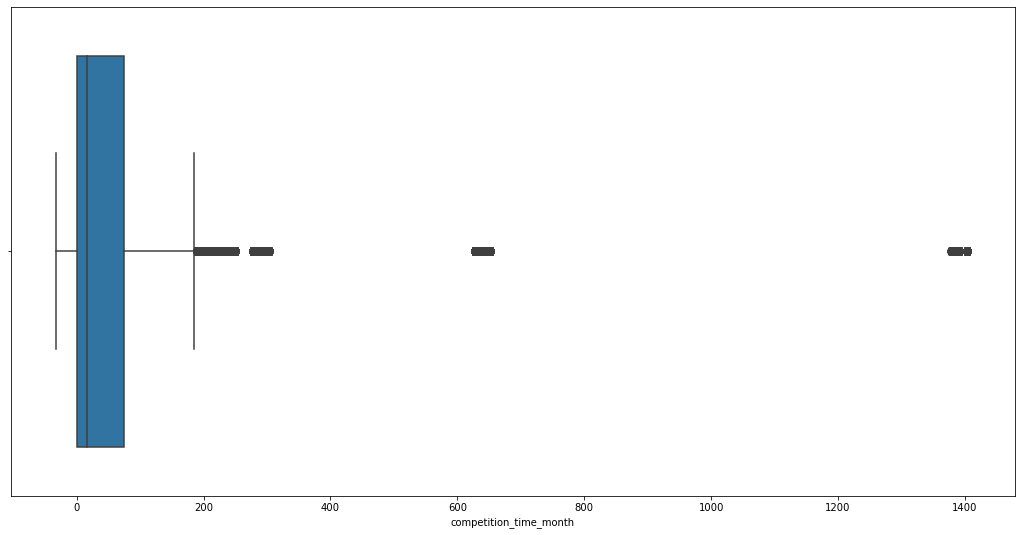

In [73]:
plt.figure(figsize=(18, 9))
sns.boxplot( dataset5['competition_time_month'] )

In [74]:
rs = RobustScaler()
dataset5['competition_time_month'] = rs.fit_transform( dataset5[['competition_time_month']].values )
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

<AxesSubplot:xlabel='competition_time_month', ylabel='Density'>

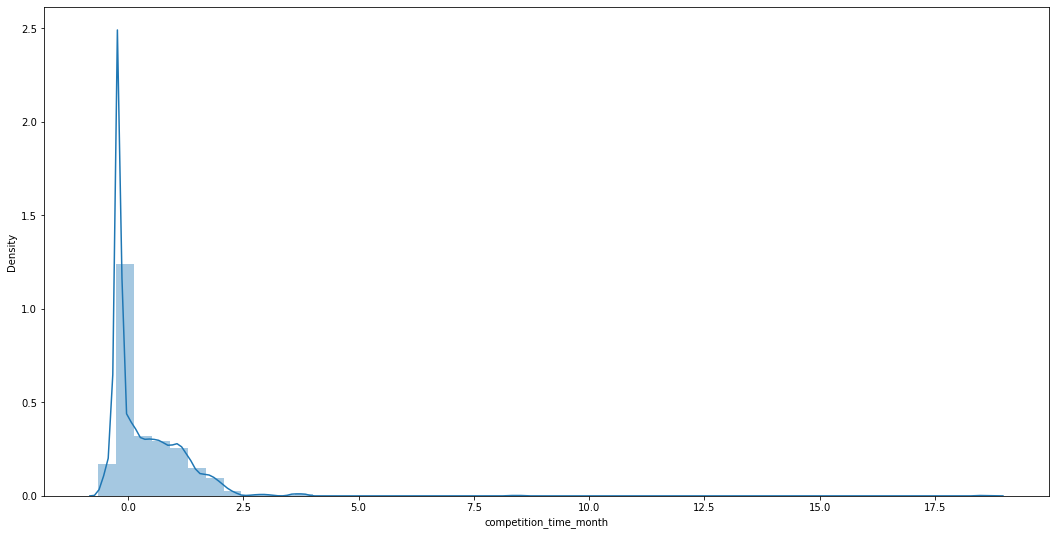

In [75]:
plt.figure(figsize=(18, 9))
sns.distplot( dataset5['competition_time_month'] )

##### Promo time week

<AxesSubplot:xlabel='promo_time_week'>

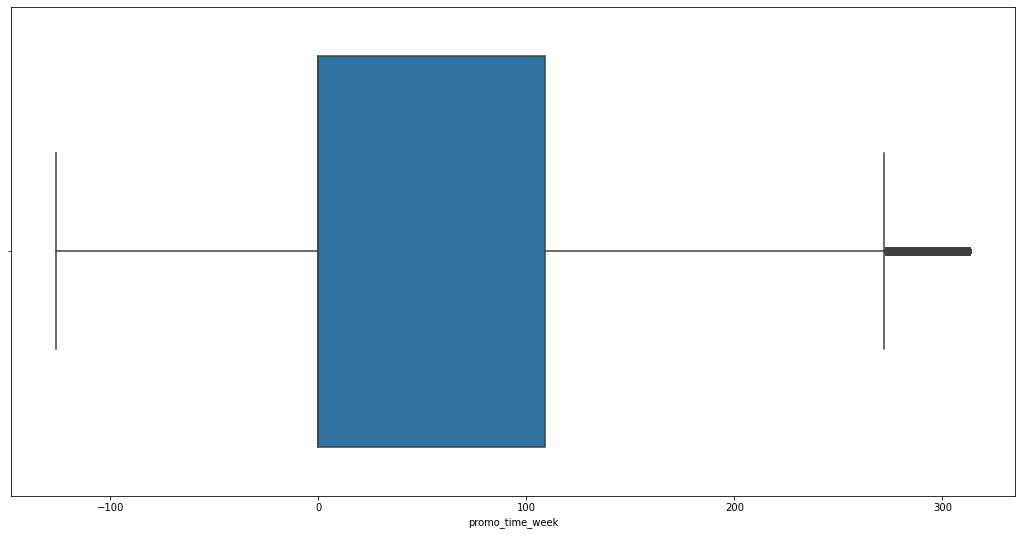

In [76]:
plt.figure(figsize=(18, 9))
sns.boxplot( dataset5['promo_time_week'] )

In [77]:
mms = MinMaxScaler()
dataset5['promo_time_week'] = mms.fit_transform( dataset5[['promo_time_week']].values )
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

<AxesSubplot:xlabel='promo_time_week', ylabel='Density'>

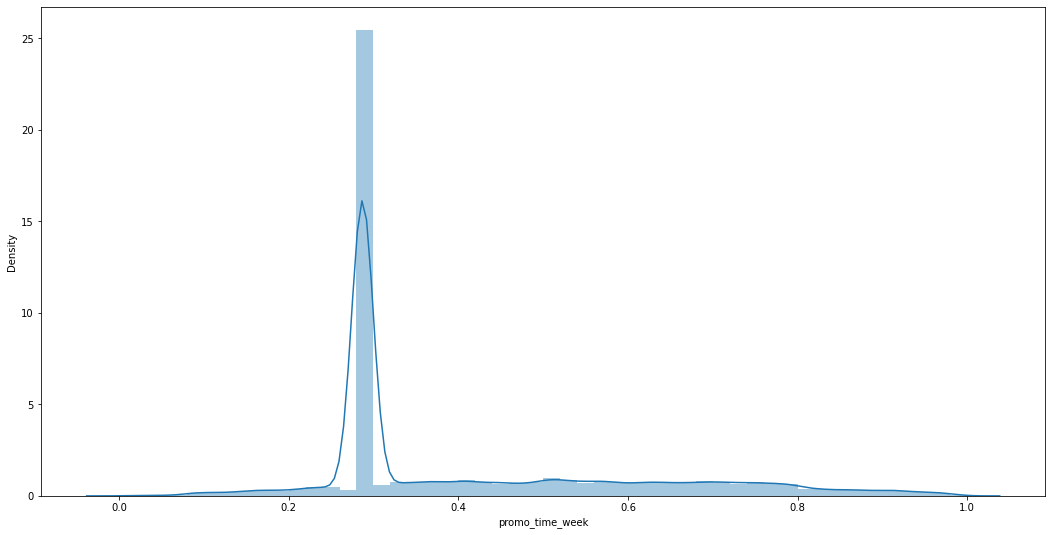

In [78]:
plt.figure(figsize=(18, 9))
sns.distplot( dataset5['promo_time_week'] )

##### Year

<AxesSubplot:xlabel='year'>

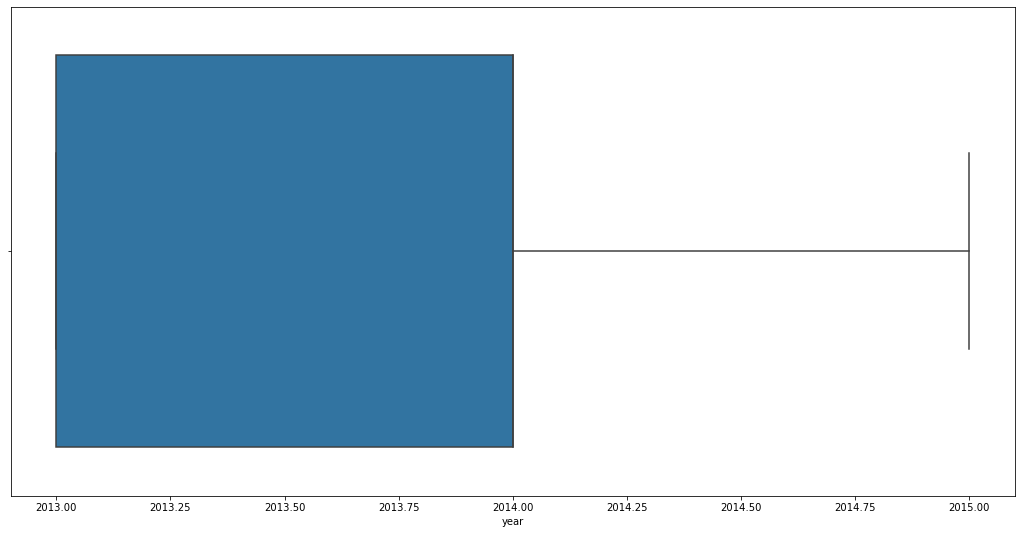

In [79]:
plt.figure(figsize=(18, 9))
sns.boxplot( dataset5['year'] )

In [80]:
mms = MinMaxScaler()
dataset5['year'] = mms.fit_transform( dataset5[['year']].values )
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

### 6.3 Transformation

**Transformation Types:**

- Logarithm Transformation
- Box-Cox Transformation
- Cube-Root Transformation
- Square-Root Transformation
- Sine and Cosine Transformation

#### 6.3.1 Encoding

**Encoding Types:**

- One Hot Encoding
- Label Encoding
- Ordinal Encoding
- Target Encoding
- Frequency Encoding
- Embedding Encoding

##### State holiday

In [81]:
# One Hot Encoding
dataset5 = pd.get_dummies( dataset5, prefix=['state_holiday'], columns=['state_holiday'] )

##### Store type

In [82]:
# Label Encoding
le = LabelEncoder()
dataset5['store_type'] = le.fit_transform( dataset5['store_type'] )
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

##### Assortment

In [83]:
dataset5[ 'assortment' ].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [84]:
# Ordinal Encoding
assortment_dict= { 'basic':1, 'extra':2, 'extended':3 }
dataset5['assortment'] = dataset5['assortment'].map( assortment_dict )

#### 6.3.2 Response Variable Transformation

<AxesSubplot:xlabel='sales', ylabel='Density'>

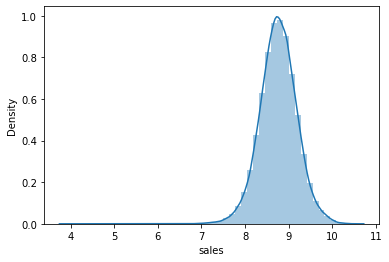

In [85]:
# Logarithm Transformation
dataset5['sales'] = np.log( dataset5['sales'] )
sns.distplot( dataset5['sales'] )

#### 6.3.3 Nature Transformation

##### Month

In [86]:
# Sine and Cosine Transformation
dataset5['month_sin'] = dataset5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
dataset5['month_cos'] = dataset5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

##### Day

In [87]:
# Sine and Cosine Transformation
dataset5['day_sin'] = dataset5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
dataset5['day_cos'] = dataset5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

##### Week of year

In [88]:
# Sine and Cosine Transformation
dataset5['week_of_year_sin'] = dataset5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
dataset5['week_of_year_cos'] = dataset5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

##### Day of week

In [89]:
# Sine and Cosine Transformation
dataset5['day_of_week_sin'] = dataset5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
dataset5['day_of_week_cos'] = dataset5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [90]:
dataset5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568456,1,1,2,1,-0.171799,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710125,1,1,0,1,-0.285251,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025696,1,1,0,1,1.912480,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546455,1,1,2,3,-0.277147,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.480944,1,1,0,1,4.470016,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


## 7.0 FEATURE SELECTION

Collinear Variables - Using one of the 3 variable selection methods, these 'collenear variables' are removed for explaining the same thing.

**Variable Selection Methods:**
- Filter Methods
- Embedded Methods
- Wrapper Methods  (Algoritmo de Feature Selection - Boruta)


In [91]:
# Copy of data
dataset6 = dataset5.copy()

### 7.1 Split dataframe into training and test dataset

In [92]:
dataset6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568456,1,1,2,1,-0.171799,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710125,1,1,0,1,-0.285251,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025696,1,1,0,1,1.912480,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546455,1,1,2,3,-0.277147,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.480944,1,1,0,1,4.470016,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [93]:
# Identify derived variables and delete original ones
cols_drop = ['day_of_week', 'day', 'month', 'week_of_year', 'promo_since', 'competition_since', 'year_week' ]
dataset6 = dataset5.drop( cols_drop, axis=1)

In [94]:
dataset6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [95]:
dataset6[['store', 'date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [96]:
dataset6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [97]:
# Training dataset
X_train = dataset6[dataset6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test dataset
X_test = dataset6[dataset6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() )  )
print( 'Training Max Date: {}'.format( X_train['date'].max() )  )

print( '\nTest Min Date: {}'.format( X_test['date'].min() )  )
print( 'Test Min Date: {}'.format( X_test['date'].max() )  )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


### 7.2 Boruta as Feature Selection

In [98]:
# Training and Test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1 ).values
Y_train_n = Y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1)

# Define Boruta
boruta = BorutaPy( rf, n_estimators ='auto', verbose=2, random_state=42 ).fit( X_train_n, Y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


#### 7.2.1 Best Features from Boruta

In [99]:
cols_selected = boruta.support_.tolist()

# Best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected Boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

In [100]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [101]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

### 7.3 Manual Feature Selection

In [102]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
#cols_selected_boruta.extend(feat_to_add)

In [103]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

## 8.0 MACHINE LEARNING MODELLING

In [104]:
# Copy of data
dataset7 = dataset6.copy()

In [105]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

### 8.1 Average Model

In [106]:
# Function Average Model

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs(( y - yhat ) / y  ))

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat )) 
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [107]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[[ 'store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales': 'predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800167,0.45515,1835.141019


### 8.2 Linear Regression Model

In [108]:
# model
lr = LinearRegression().fit( x_train, Y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( Y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1872.777078,0.293688,2672.668121


### 8.3 Linear Regression Regularized Model - Lasso

In [109]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, Y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( Y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1894.244912,0.289523,2745.747045


### 8.4 Random Forest Regressor

In [110]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, Y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( Y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,672.672206,0.098964,999.832555


### 8.5 XGBoost Regressor

In [111]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01,
                              max_depth=6,
                              subsample=1,
                              colsample_bytree=1 ).fit( x_train, Y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.723335,0.949004,7334.453645


### 8.6 Comparing the Models

#### 8.6.1 Single Performance

In [112]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result ])
modelling_result.sort_values ('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,672.672206,0.098964,999.832555
0,Average Model,1354.800167,0.455150,1835.141019
0,Linear Regression,1872.777078,0.293688,2672.668121
0,Linear Regression Lasso,1894.244912,0.289523,2745.747045
0,XGBoost Regressor,6683.723335,0.949004,7334.453645


#### 8.6.2 Time Series Cross-Validation

In [113]:
cols_selected_boruta.extend(feat_to_add)
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

In [114]:
x_training = X_train[ cols_selected_boruta ]

In [115]:
# Function Cross Validation
def cross_validation(xtraining, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        if verbose: 
            print('\n KFold number {}'.format(k))
            
        # Start and End date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training and validation dataset
        
        # training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)
        
        # Prediction
        yhat= m.predict(xvalidation)
        
        # Performance
        model_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # Store performance of each iteration
        mae_list.append(model_result['MAE'])
        mape_list.append(model_result['MAPE'])
        rmse_list.append(model_result['RMSE'])
        
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- '  + np.round(np.std(mae_list),2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)
    }, index=[0])


##### 8.6.2.1  Linear Regression Model - Cross Validation

In [116]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

In [117]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2084.2 +/- 295.6,0.3 +/- 0.02,2950.77 +/- 468.25


##### 8.6.2.2   Linear Regression Regularized Model - Cross Validation


In [118]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Lasso', lrr, verbose=False )

In [119]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Lasso,2118.04 +/- 341.23,0.29 +/- 0.01,3058.08 +/- 503.75


##### 8.6.2.3 Random Forest Regressor - Cross Validation

In [120]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )

In [121]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.23 +/- 219.78,0.12 +/- 0.02,1254.52 +/- 321.29


##### 8.6.2.4 XGBoost Regressor - Cross Validation

In [122]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )


 KFold number 5

 KFold number 4

 KFold number 3

 KFold number 2

 KFold number 1


In [123]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7048.48 +/- 589.37,0.95 +/- 0.0,7717.79 +/- 689.77


#### 8.6.3 Real Performance - Cross Validation

In [124]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2084.2 +/- 295.6,0.3 +/- 0.02,2950.77 +/- 468.25
0,Linear Regression Lasso,2118.04 +/- 341.23,0.29 +/- 0.01,3058.08 +/- 503.75
0,Random Forest Regressor,837.23 +/- 219.78,0.12 +/- 0.02,1254.52 +/- 321.29
0,XGBoost Regressor,7048.48 +/- 589.37,0.95 +/- 0.0,7717.79 +/- 689.77


## 9.0 HYPERPARAMETER FINE TUNING

### 9.1 Random Search

In [125]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500], 
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 2

In [126]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # Chose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )


    # performance
    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,958.42 +/- 76.87,0.13 +/- 0.01,1386.19 +/- 145.04
0,XGBoost Regressor,1350.8 +/- 56.05,0.18 +/- 0.0,1964.61 +/- 96.09


### 9.2 Final Model

In [141]:
param_tuned = {
    'n_estimators': 2500, 
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.3,
    'min_child_weight': 8
        }

MAX_EVAL = 2

In [142]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'], 
                              eta=param_tuned['eta'],
                              max_depth=param_tuned['max_depth'],
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, Y_train )


# prediction
yhat_xgb_tuned = model_xgb.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1211.46205,0.180103,1754.919525


In [143]:
# Saving model
import pickle
filename = 'model/model_xgb_tuned.pkl'
pickle.dump(model_xgb_tuned, open(filename, 'wb'))

## 10.0 TRANSLATION AND INTERPRETATION OF THE ERROR

In [144]:
# Copy of data
dataset9 = X_test[cols_selected_boruta]

# Rescale
dataset9['sales']= np.expm1(dataset9['sales'])
dataset9['predictions']= np.expm1( yhat_xgb_tuned )


C:\Users\Usuario\AppData\Local\Temp/ipykernel_11184/551140878.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset9['sales']= np.expm1(dataset9['sales'])
C:\Users\Usuario\AppData\Local\Temp/ipykernel_11184/551140878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset9['predictions']= np.expm1( yhat_xgb_tuned )


### 10.1 Business Performance

In [145]:
# Sum of predictions
dataset91 = dataset9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
dataset9_aux1 = dataset9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAE'} )
dataset9_aux2 = dataset9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAPE'} )

# Merge
dataset9_aux3 = pd.merge( dataset9_aux1, dataset9_aux2, how='inner', on='store')
dataset92 = pd.merge( dataset91 , dataset9_aux3, how='inner', on='store')

# Scenarios
dataset92['worst_scenario'] = dataset92['predictions'] - dataset92['MAE']
dataset92['best_scenario'] = dataset92['predictions'] + dataset92['MAE']

# Order Columns
dataset92 = dataset92[[ 'store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ]]

In [146]:
dataset92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
14,15,272644.375000,271894.845901,273393.904099,749.529099,0.113218
572,573,184048.015625,182983.944158,185112.087092,1064.071467,0.293983
390,391,217354.875000,216554.276367,218155.473633,800.598633,0.205372
309,310,282022.468750,279682.182259,284362.755241,2340.286491,0.270032


In [147]:
# worst scenarios
dataset92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
472,473,218219.343750,215599.766826,220838.920674,2619.576924,0.838104
291,292,128105.218750,124452.034411,131758.403089,3653.184339,0.778204
424,425,199489.328125,197260.508354,201718.147896,2228.819771,0.778047
969,970,164439.281250,162774.733273,166103.829227,1664.547977,0.746507
434,435,186327.812500,184281.763500,188373.861500,2046.049000,0.696960


<AxesSubplot:xlabel='store', ylabel='MAPE'>

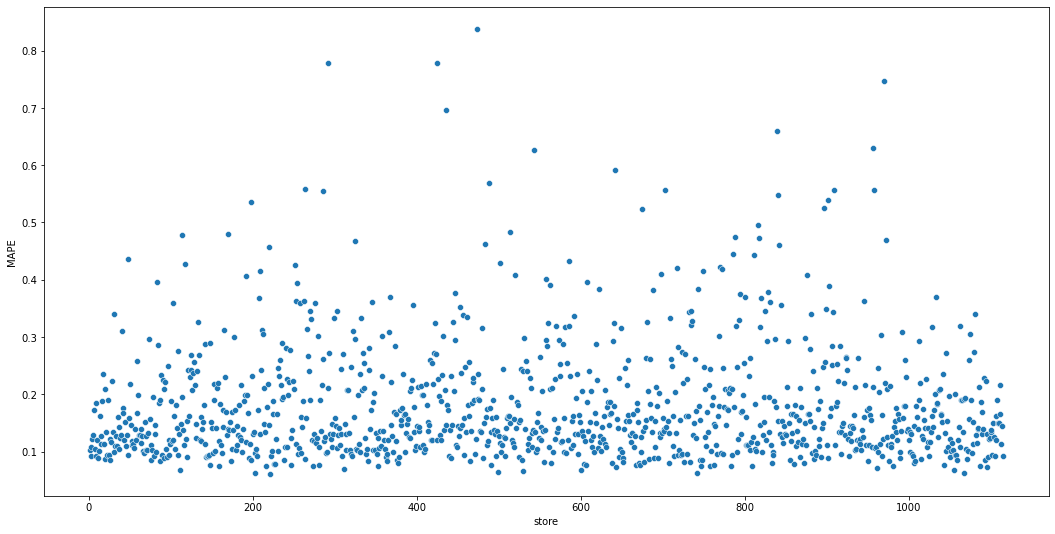

In [148]:
plt.figure(figsize=(18, 9))
sns.scatterplot( x='store', y='MAPE', data=dataset92)

### 10.2 Total Performance

In [149]:
dataset93 = dataset92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0 ).reset_index().rename( columns={ 'index': 'Scenario', 0:'Values'} )
dataset93['Values'] = dataset93['Values'].map( 'R${:,.2f}'.format)
dataset93

,Scenario,Values
0,predictions,"R$276,616,256.00"
1,worst_scenario,"R$275,263,336.55"
2,best_scenario,"R$277,969,184.46"


### 10.3 Machine Learning Performance

In [150]:
dataset9['error'] = dataset9['sales'] - dataset9['predictions']
dataset9['error_rate'] = dataset9['predictions'] / dataset9['sales']

C:\Users\Usuario\AppData\Local\Temp/ipykernel_11184/3493533406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset9['error'] = dataset9['sales'] - dataset9['predictions']
C:\Users\Usuario\AppData\Local\Temp/ipykernel_11184/3493533406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset9['error_rate'] = dataset9['predictions'] / dataset9['sales']


<AxesSubplot:xlabel='predictions', ylabel='error'>

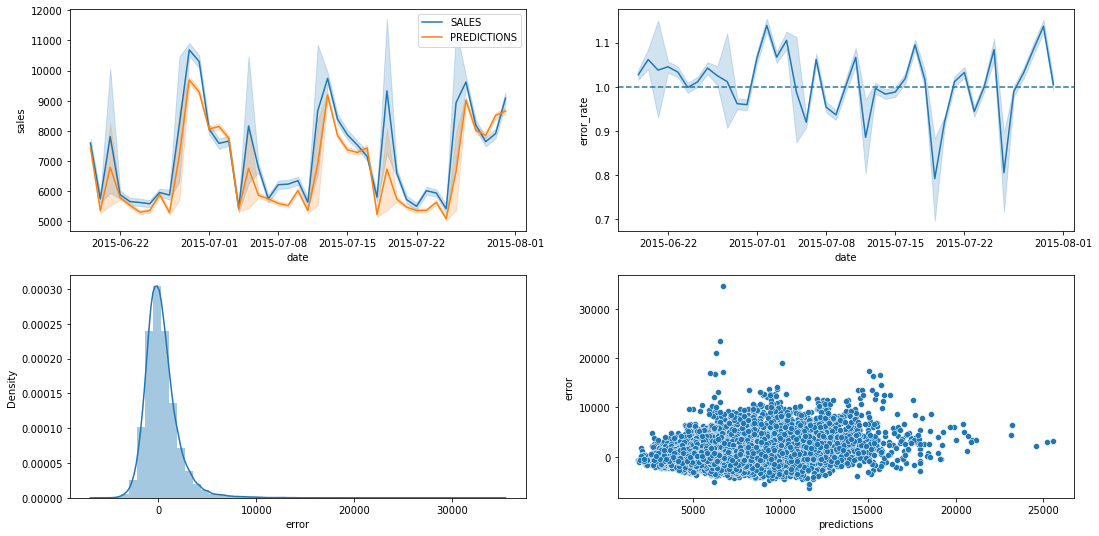

In [151]:
plt.figure(figsize=(18, 9))

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=dataset9, label='SALES')
sns.lineplot( x='date', y='predictions', data=dataset9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=dataset9 )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( dataset9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( dataset9['predictions'], dataset9['error'] )

## 11.0 DEPLOY MODEL TO PRODUCTION

In [152]:
# Saving trained model
pickle.dump( model_xgb_tuned, open( 'C:/Users/Usuario/Projetos/Rossmann-Store-Sales/model/model_xgb_tuned.pkl', 'wb' ) )

### 11.1 Rossmann Class

In [139]:
import math
import pickle
import datetime
import inflection
import pandas as pd
import numpy  as np



class Rossmann (object):
    def __init__(self):
        state = 1
        self.home_path = 'C:/Users/Usuario/Projetos/Rossmann-Store-Sales/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, dataset1):

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        def snakecase(x): return inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))
        
        # rename
        dataset1.columns = cols_new
        
        # Dta Types
        dataset1['date'] = pd.to_datetime(dataset1['date'])

        # Fillout N/A
        # competition_distance
        dataset1['competition_distance'] = dataset1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        # competition_open_since_month
        dataset1['competition_open_since_month'] = dataset1.apply(lambda x: x['date'].month if math.isnan(
            x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        dataset1['competition_open_since_year'] = dataset1.apply(lambda x: x['date'].year if math.isnan(
            x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        dataset1['promo2_since_week'] = dataset1.apply(lambda x: x['date'].week if math.isnan(
            x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
            x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        dataset1['promo_interval'].fillna(0, inplace=True)
        dataset1['month_map'] = df1['date'].dt.month.map(month_map)

        # eh promocao quando a promo2 coincide com a date
        dataset1['is_promo'] = dataset1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        # 1.6. Change Types
        dataset1['competition_open_since_month'] = dataset1['competition_open_since_month'].astype(int)
        dataset1['competition_open_since_year']  = dataset1['competition_open_since_year'].astype(int)
        dataset1['promo2_since_week']            = dataset1['promo2_since_week'].astype(int)
        dataset1['promo2_since_year']            = dataset1['promo2_since_year'].astype(int)

        return dataset1

    def feature_engineering(self, dataset2):

        # year
        dataset2['year'] = dataset2['date'].dt.year

        # month
        dataset2['month'] = dataset2['date'].dt.month
        
        # day
        dataset2['day'] = dataset2['date'].dt.day
        
        # week of year
        dataset2['week_of_year'] = dataset2['date'].dt.weekofyear
        
        # year week
        dataset2['year_week'] = dataset2['date'].dt.strftime('%Y-%W')

        # competition since
        dataset2['competition_since'] = dataset2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        
        # competition time month
        dataset2['competition_time_month'] = ((dataset2['date'] - dataset2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        # promo since
        dataset2['promo_since'] = dataset2['promo2_since_year'].astype(str) + '-'+ dataset2['promo2_since_week'].astype(str)
        dataset2['promo_since'] = dataset2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
       
        # promo time week
        dataset2['promo_time_week'] = ((dataset2['date'] - dataset2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        dataset2['assortment'] = dataset2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
       
        # state holiday
        dataset2['state_holiday'] = dataset2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # Variabl filtering
        # Line filtering
        dataset2 = dataset2[dataset2['open'] != 0]

        # Delet restrictions
        cols_drop = ['open', 'promo_interval', 'month_map']
        dataset2 = dataset2.drop(cols_drop, axis=1)

        return dataset2

    def data_preparation(self, dataset5):

        ## Rescaling

        # Apply RobustScaler
        dataset5['competition_distance'] = self.competition_distance_scaler.fit_transform(dataset5[['competition_distance']].values)
        
        # competition time month
        dataset5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(dataset5[['competition_time_month']].values)

        # promotimeweek
        dataset5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(dataset5[['promo_time_week']].values)

        # year
        dataset5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## Encoding

        # One hot encoding - State holiday
        dataset5 = pd.get_dummies(dataset5, prefix=['state_holiday'], columns=['state_holiday'])

        # Label Encoding - Store type
        dataset5['store_type'] = self.store_type_scaler.fit_transform(dataset5['store_type'])

        # Assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
        dataset5['assortment'] = dataset5['assortment'].map(assortment_dict)

        # Nature Transformation
        # month
        dataset5['month_sin'] = dataset5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
        dataset5['month_cos'] = dataset5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

        # day
        dataset5['day_sin'] = dataset5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
        dataset5['day_cos'] = dataset5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

        # week of year
        dataset5['week_of_year_sin'] = dataset5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
        dataset5['week_of_year_cos'] = dataset5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

        # day of week
        dataset5['day_of_week_sin'] = dataset5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
        dataset5['day_of_week_cos'] = dataset5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

        cols_selected = [

            'store',
            'promo',
            'store_type',
            'assortment',
            'competition_distance',
            'competition_open_since_month',
            'competition_open_since_year',
            'promo2',
            'promo2_since_week',
            'promo2_since_year',
            'competition_time_month',
            'promo_time_week',
            'month_sin',
            'month_cos',
            'day_sin',
            'day_cos',
            'week_of_year_sin',
            'week_of_year_cos',
            'day_of_week_sin',
            'day_of_week_cos'

        ]

        return dataset5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # get prediction
        pred = model.predict(test_data)

        # join
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')
     

### 11.2 API Handler

In [140]:
import os
import pickle
import pandas as pd

from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('C:/Users/Usuario/Projetos/Rossmann-Store-Sales/model/model_xgb_tuned.pkl', 'rb'))

# Initialize API
app = Flask(__name__)


@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    # There is data
    if test_json:
        
        # Unique example
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        
        # Multiple example
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        dataset1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        dataset2 = pipeline.feature_engineering(dataset1)

        # data preparation
        dataset3 = pipeline.data_preparation(dataset2)

        # prediction
        dataset_response = pipeline.get_prediction(model, test_raw, dataset3)
        
        return dataset_response

    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run(host='0.0.0.0', port=port)

ModuleNotFoundError: No module named 'rossmann'

### 11.3 API Tester

In [153]:
import requests

In [154]:
# Loading test dataset
dataset10 = pd.read_csv( 'C:/Users/Usuario/Projetos/Rossmann-Store-Sales/data/test.csv' )

In [155]:
# merge test dataset + store
dataset_test = pd.merge( dataset10, dataset_store_raw, how='left', on='Store' )

# choose store for prediction
dataset_test = dataset_test[dataset_test['Store'].isin( [24, 12, 22] ) ]

# remove closed days
dataset_test = dataset_test[dataset_test['Open'] != 0 ]
dataset_test = dataset_test[~dataset_test['Open'].isnull()]
dataset_test = dataset_test.drop( 'Id', axis=1 )


In [156]:
# API CallConvert DataFrame to json
data = json.dumps( dataset_test.to_dict ( orient='records' ) )

In [157]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url: /rossmann/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001922E31E0A0>: Failed to establish a new connection: [WinError 10049] O endereço solicitado não é válido no contexto'))

In [158]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

NameError: name 'r' is not defined

In [159]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len(d2) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 week'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

KeyError: "['prediction'] not in index"

The End